# Подготовка исходных данных

Описывается порядок получения исходных данных для трех модулей: Ф35, Ф26, Ф36.

Оптимальная подготовка исходных данных остается на усмотрение реализации АПИ. Тем не менее, основная логика должна подготовки должна быть учтена.

In [71]:
USER_SCENARIO_ID = 615 #610 тоже хороший сценарий

In [72]:
import pandas as pd
import geopandas as gpd

import prostor.fetchers.scenarios as scenarios
import prostor.fetchers.projects as projects
import prostor.fetchers.territories as territories
import prostor.fetchers.misc as misc

from blocksnet.config import log_config

log_config.set_logger_level('ERROR')

## 1. Получение слоя городских кварталов

- Получение слоя городских кварталов необходимо выполнять отдельно для территории **контекста** и отдельно для территории самого сценарного **проекта**. 
- Результатом будет являться **объединенный слой** тех и других геометрий.
- Для самой территории необходимо учитывать геометрии дорог как до, так и после преобразования для более детального анализа.

Легенда:

- `POF` -- physical object function
- `POT` -- physical object type

In [73]:
BUILDING_POF_ID = 1
WATER_POF_ID = 4
ROADS_POF_ID = 26

LIVING_BUILDING_POT_ID = 4

### 1.1. Вспомогательный код

Данный метод `close_gaps` необходим для дружбы геометрий дорог, которые граничат рядом но не соприкасаются на перекрестках точь-в-точь.

Так как мы не хотим цеплять всю библиотеку `momepy` ради одного метода, мы просто честно его скопируем.

In [74]:
from blocksnet.blocks.cutting import preprocess_urban_objects, cut_urban_blocks

import shapely
import numpy as np

def close_gaps(gdf, tolerance): # taken from momepy
    geom = gdf.geometry.array
    coords = shapely.get_coordinates(geom)
    indices = shapely.get_num_coordinates(geom)

    edges = [0]
    i = 0
    for ind in indices:
        ix = i + ind
        edges.append(ix - 1)
        edges.append(ix)
        i = ix
    edges = edges[:-1]
    points = shapely.points(np.unique(coords[edges], axis=0))

    buffered = shapely.buffer(points, tolerance / 2)

    dissolved = shapely.union_all(buffered)

    exploded = [
        shapely.get_geometry(dissolved, i)
        for i in range(shapely.get_num_geometries(dissolved))
    ]

    centroids = shapely.centroid(exploded)

    snapped = shapely.snap(geom, shapely.union_all(centroids), tolerance)

    return gpd.GeoSeries(snapped, crs=gdf.crs)

Получение **границ** территорий проекта и контекста

In [75]:
def _get_project_boundaries(project_id : int):
    return gpd.GeoDataFrame(geometry=[projects.get_project_geometry(project_id)], crs=4326)

def _get_context_boundaries(project_id : int) -> gpd.GeoDataFrame:
    project = projects.get_project(project_id)
    context_ids = project['properties']['context']
    geometries = [territories.get_territory_geometry(territory_id) for territory_id in context_ids]
    return gpd.GeoDataFrame(geometry=geometries, crs=4326)

Получение **дорог** сценария (подразумевается для базового и пользовательского) и контекста

In [76]:
def _get_scenario_roads(scenario_id : int):
    gdf = scenarios.get_physical_objects(scenario_id, physical_object_function_id=ROADS_POF_ID)
    return gdf[['geometry']].reset_index(drop=True)

def _get_context_roads(project_id : int):
    gdf = projects.get_physical_objects(project_id, physical_object_function_id=ROADS_POF_ID)
    return gdf[['geometry']].reset_index(drop=True)

Получение **водных объектов** сценария и контекста

In [77]:
def _get_scenario_water(scenario_id : int):
    gdf = scenarios.get_physical_objects(scenario_id, physical_object_function_id=WATER_POF_ID)
    return gdf[['geometry']].reset_index(drop=True)

def _get_context_water(project_id : int):
    gdf = projects.get_physical_objects(project_id, physical_object_function_id=WATER_POF_ID)
    return gdf[['geometry']].reset_index(drop=True)

Получение геометрий **кварталов** сценария и контекста

In [78]:
def _get_scenario_blocks(user_scenario_id : int, base_scenario_id : int, boundaries : gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    crs = boundaries.estimate_utm_crs()
    boundaries = boundaries.to_crs(crs)
    boundaries.geometry = boundaries.buffer(-1)
    
    water = _get_scenario_water(user_scenario_id).to_crs(crs)

    user_roads = _get_scenario_roads(user_scenario_id)
    base_roads = _get_scenario_roads(base_scenario_id)
    roads = pd.concat([user_roads, base_roads]).reset_index(drop=True).to_crs(crs)
    roads.geometry = close_gaps(roads, 1)
    
    lines, polygons = preprocess_urban_objects(roads, None, water)
    blocks = cut_urban_blocks(boundaries, lines, polygons)
    return blocks.to_crs(4326)

def _get_context_blocks(project_id : int, boundaries : gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    crs = boundaries.estimate_utm_crs()
    boundaries = boundaries.to_crs(crs)
    boundaries.geometry = boundaries.buffer(-1)

    water = _get_context_water(project_id).to_crs(crs)
    roads = _get_context_roads(project_id).to_crs(crs)
    roads.geometry = close_gaps(roads, 1)

    lines, polygons = preprocess_urban_objects(roads, None, water)
    blocks = cut_urban_blocks(boundaries, lines, polygons)
    return blocks.to_crs(4326)

Получение **функциональных зон** сценария и контекста для наилучших случаев

In [79]:
from prostor.adapters import adapt_functional_zones

SOURCES_PRIORITY = ['User', 'PZZ', 'OSM']

def _get_best_functional_zones_source(sources_df : pd.DataFrame) -> tuple[int | None, str | None]:
    sources = sources_df['source'].unique()
    for source in SOURCES_PRIORITY:
        if source in sources:
            sources_df = sources_df[sources_df['source'] == source]
            year = sources_df.year.max()
            return int(year), source
    return None, None #FIXME ??? 

def _get_scenario_functional_zones(scenario_id : int) -> gpd.GeoDataFrame:
    sources_df = scenarios.get_functional_zones_sources(scenario_id)
    year, source = _get_best_functional_zones_source(sources_df)
    functional_zones = scenarios.get_functional_zones(scenario_id, year, source)
    return adapt_functional_zones(functional_zones)

def _get_context_functional_zones(project_id : int) -> gpd.GeoDataFrame:
    sources_df = projects.get_functional_zones_sources(project_id)
    year, source = _get_best_functional_zones_source(sources_df)
    functional_zones = projects.get_functional_zones(project_id, year, source)
    return adapt_functional_zones(functional_zones)

Получение **жилых зданий** контекста

P.S: Для **сценария** нет необходимости, потому что мы их все равно зануляем

In [80]:
from prostor.adapters import adapt_buildings
from blocksnet.preprocessing.imputing import impute_buildings

def _get_context_buildings(project_id : int):
    gdf = projects.get_physical_objects(project_id, physical_object_type_id=LIVING_BUILDING_POT_ID, centers_only=True)
    gdf = adapt_buildings(gdf.reset_index(drop=True))
    crs = gdf.estimate_utm_crs()
    return impute_buildings(gdf.to_crs(crs)).to_crs(4326)

Получаем необходимые типы сервисов:

- свободно мапятся в блокснет
- есть `infrastructure_type` или `social_values`

In [81]:
from prostor.adapters import adapt_service_types

def get_service_types():
  service_types = misc.get_service_types()
  return adapt_service_types(service_types)

Получение **сервисов** контекста

- для **сценария** нет необходимости, потому что мы их все равно зануляем
- работаем только с полученными **типами сервисов**

In [82]:
from prostor.adapters import adapt_services
from blocksnet.preprocessing.imputing import impute_services

def _get_context_services(project_id : int, service_types : pd.DataFrame):
    gdf = projects.get_services(project_id, centers_only=True)
    gdfs = adapt_services(gdf.reset_index(drop=True), service_types)
    return {st:impute_services(gdf,st) for st,gdf in gdfs.items()}

Полный **пайплайн** для сценария и контекста, каждый включает следующие этапы:
- Получение геометрий **кварталов**.
- Получение геометрий **функциональных зон** и их назначение кварталам.
- Получение **зданий** и их агрегация в рамках кварталов.
- Получение **сервисов** и их агрегация в рамках кварталов.

In [83]:
from prostor.adapters import LAND_USE_RULES
from blocksnet.blocks.aggregation import aggregate_objects
from blocksnet.blocks.assignment import assign_land_use

def _scenario_pipeline(user_scenario_id : int, base_scenario_id : int, boundaries : gpd.GeoDataFrame) -> gpd.GeoDataFrame:
  blocks = _get_scenario_blocks(user_scenario_id, base_scenario_id, boundaries)
  crs = blocks.estimate_utm_crs()
  blocks = blocks.to_crs(crs)

  functional_zones = _get_scenario_functional_zones(user_scenario_id).to_crs(crs)
  blocks = assign_land_use(blocks, functional_zones, LAND_USE_RULES)
  blocks = blocks[['geometry', 'land_use']].copy()
  
  return blocks.to_crs(4326)

def _context_pipeline(project_id : int, boundaries : gpd.GeoDataFrame, service_types : pd.DataFrame) -> gpd.GeoDataFrame:
  blocks = _get_context_blocks(project_id, boundaries)
  crs = blocks.estimate_utm_crs()
  blocks = blocks.to_crs(crs)

  functional_zones = _get_context_functional_zones(project_id).to_crs(crs)
  blocks = assign_land_use(blocks, functional_zones, LAND_USE_RULES)
  blocks = blocks[['geometry', 'land_use']].copy()

  buildings = _get_context_buildings(project_id).to_crs(crs)
  blocks_buildings, _ = aggregate_objects(blocks, buildings)
  blocks['population'] = blocks_buildings['population']

  services_dict = _get_context_services(project_id, service_types)
  for service_type, services in services_dict.items():
    services = services.to_crs(crs)
    blocks_capacities, _ = aggregate_objects(blocks, services)
    blocks[f'capacity_{service_type}'] = blocks_capacities['capacity']

  return blocks.to_crs(4326)

Получение **ИТОГОВЫХ** кварталов для пользовательского сценария -- входная точка
P.S: плюс типы сервисов 

In [84]:
service_types = get_service_types()

In [97]:
def _get_scenario_info(scenario_id : int) -> tuple[int, int]:
    scenario = scenarios.get_scenario(scenario_id)
    project_id = scenario['project']['project_id']
    project = projects.get_project(project_id)
    base_scenario_id = project['base_scenario']['id']
    return project_id, base_scenario_id

def pipeline(user_scenario_id : int, service_types : pd.DataFrame):
    project_id, base_scenario_id = _get_scenario_info(user_scenario_id)
    project_boundaries = _get_project_boundaries(project_id)
    context_boundaries = _get_context_boundaries(project_id).overlay(project_boundaries, how='difference')

    scenario_blocks = _scenario_pipeline(user_scenario_id, base_scenario_id, project_boundaries)
    scenario_blocks['is_context'] = False
    context_blocks = _context_pipeline(project_id, context_boundaries, service_types)
    context_blocks['is_context'] = True
    blocks = pd.concat([scenario_blocks, context_blocks]).reset_index(drop=True)
    
    non_int_column = ['land_use', 'geometry', 'is_context']
    int_columns = [column for column in blocks.columns if column not in non_int_column]
    blocks[int_columns] = blocks[int_columns].fillna(0).astype(int)
    
    crs = blocks.estimate_utm_crs()
    return blocks.to_crs(crs)

blocks = pipeline(USER_SCENARIO_ID, service_types)

### 2. Получение матрицы доступности

Так как для матрицы доступности требуется интермодальный граф, а его каким-то образом надо забрать с учетом сценарных изменений, в данном примере сборка такого графа будет пропущена. Вместо этого будет допущено упрощение: 
- будет собрана матрица расстояний (метры) между кварталами;
- с учетом средней скорости пешехода `5км/ч` матрица расстояний будет приведена к матрице доступности (минуты).

In [98]:
from blocksnet.relations import calculate_distance_matrix

SPEED = 5 * 1_000 / 60

def get_accessibility_matrix(blocks : gpd.GeoDataFrame) -> pd.DataFrame:
  crs = blocks.estimate_utm_crs()
  dist_mx = calculate_distance_matrix(blocks.to_crs(crs))
  return dist_mx / SPEED

In [99]:
acc_mx = get_accessibility_matrix(blocks)

## 2. Результат

1. Получен слой кварталов с зонированием, населением и капасити а также столбцом `is_context`, указывающим является ли квартал контекстом или принадлежит территории проекта.

In [100]:
blocks.head()

,geometry,land_use,is_context,population,capacity_bakery,capacity_bank,capacity_bar,capacity_cafe,capacity_dog_park,capacity_hospital,...,capacity_polyclinic,capacity_religion,capacity_restaurant,capacity_school,capacity_stadium,capacity_supermarket,capacity_swimming_pool,capacity_train_station,capacity_university,capacity_veterinary
0,"POLYGON ((388320.529 6644721.121, 388399.502 6...",LandUse.RECREATION,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"POLYGON ((388399.502 6644626.467, 388320.529 6...",LandUse.BUSINESS,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"POLYGON ((388615.909 6644560.417, 388410.707 6...",LandUse.AGRICULTURE,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"POLYGON ((388615.909 6644560.417, 388794.166 6...",LandUse.RECREATION,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"POLYGON ((388794.166 6644624.357, 388899.049 6...",LandUse.RECREATION,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


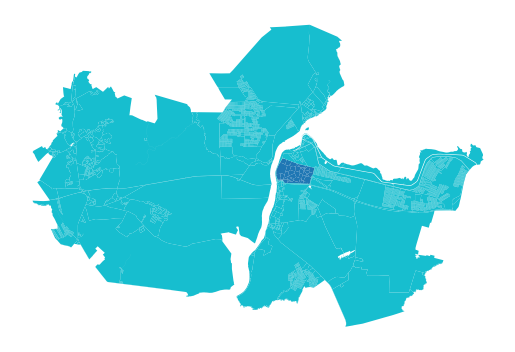

In [101]:
blocks.plot('is_context').set_axis_off()

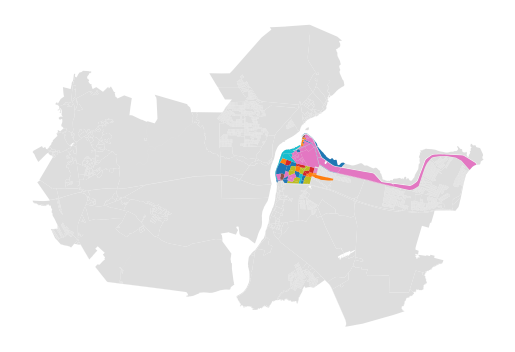

In [102]:
ax = blocks.plot(color='#ddd')
blocks.plot('land_use',ax=ax).set_axis_off()

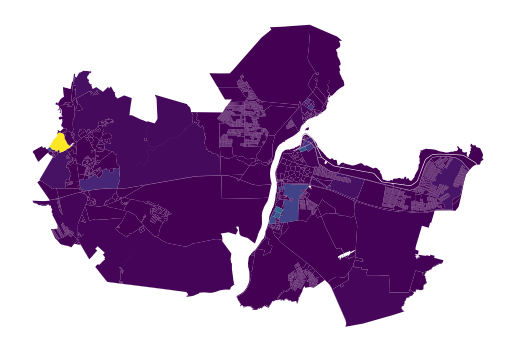

In [103]:
blocks.plot('population').set_axis_off()

In [104]:
blocks.to_pickle('./data/blocks.pickle')

2. Типы сервисов с информацией об оригинальном `id`, названии из `blocksnet` и прочих вещах

In [105]:
service_types

,name,infrastructure_type,infrastructure_weight,social_values
service_type_id,,,,
1,park,basic,0.20,[8]
5,beach,comfort,0.50,None
21,kindergarten,basic,0.20,[2]
22,school,basic,0.20,"[2, 4]"
27,university,comfort,0.20,"[4, 10, 17]"
28,polyclinic,basic,0.20,[15]
34,pharmacy,basic,0.20,[15]
35,hospital,additional,0.30,[15]
45,recruitment,None,NaN,[17]


In [106]:
service_types.to_pickle('./data/service_types.pickle')

3. Матрица доступности

In [107]:
acc_mx

,0,1,2,3,4,5,6,7,8,9,...,2690,2691,2692,2693,2694,2695,2696,2697,2698,2699
0,0.000,6.924,9.588,7.176,13.320,6.480,5.364,9.780,9.480,25.716,...,154.332,154.464,155.088,156.576,157.356,156.000,155.352,156.240,156.588,157.836
1,6.924,0.000,5.844,9.084,11.376,3.528,5.100,16.608,15.132,27.984,...,161.244,161.388,162.012,163.500,164.280,162.924,162.264,163.164,163.500,164.748
2,9.588,5.844,0.000,6.528,5.616,9.300,10.500,17.544,14.244,23.292,...,161.760,161.940,162.600,164.160,165.012,163.776,163.320,164.280,164.652,165.912
3,7.176,9.084,6.528,0.000,7.140,11.208,11.256,11.820,7.812,19.248,...,155.340,155.532,156.192,157.776,158.652,157.440,157.044,158.028,158.412,159.672
4,13.320,11.376,5.616,7.140,0.000,14.700,15.636,18.852,14.244,18.444,...,161.052,161.292,161.964,163.620,164.532,163.404,163.140,164.160,164.568,165.840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,156.000,162.924,163.776,157.440,163.404,161.604,159.684,146.496,149.628,152.928,...,9.720,8.364,7.596,5.160,3.444,0.000,5.700,7.596,8.664,9.180
2696,155.352,162.264,163.320,157.044,163.140,160.824,158.892,145.944,149.244,153.228,...,15.216,13.860,13.164,10.860,9.072,5.700,0.000,2.112,3.204,4.116
2697,156.240,163.164,164.280,158.028,164.160,161.688,159.744,146.868,150.240,154.428,...,17.232,15.876,15.144,12.744,10.848,7.596,2.112,0.000,1.104,2.100
2698,156.588,163.500,164.652,158.412,164.568,162.000,160.044,147.228,150.624,154.932,...,18.324,16.968,16.236,13.800,11.880,8.664,3.204,1.104,0.000,1.284


In [108]:
acc_mx.to_pickle('./data/acc_mx.pickle')